# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\niels\AppData\Local\Temp\ipykernel_59568\187924686.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
C:\Users\niels\AppData\Local\Temp\ipykernel_59568\187924686.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map_img = imageio.imread('./map/vivocity_freespace.png')


Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


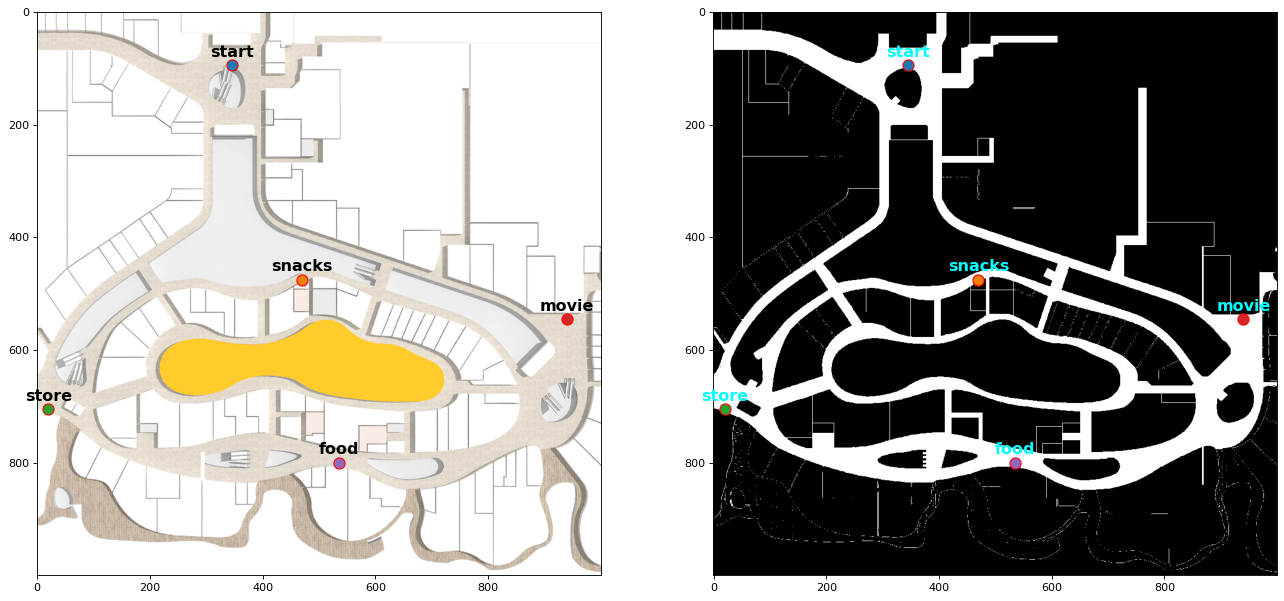

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [2]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

----------------------------------------------------------------------------------------------------
Planning path for  ('start', 'snacks')
AlgorithmOutput(
total_runtime_secs = 11.102207899093628
total_travelled_distance_m = 142.4856997824492
num_cells_visited = 36018
num_removed_from_frontiers = 15667
num_old_cells_detected = 15454
planned_path = [(345, 95), (346, 96), (347, 97), (348, 98), (349, 99), (350, 100), (351, 101), (352, 101), (353, 101), (354, 102), (355, 102), (356, 103), (357, 103), (358, 103), (359, 104), (360, 105), (361, 106), (362, 107), (363, 108), (364, 109), (365, 110), (366, 111), (366, 112), (366, 113), (367, 114), (367, 115), (368, 116), (369, 117), (369, 118), (370, 119), (371, 120), (372, 121), (373, 122), (374, 123), (374, 124), (375, 125), (375, 126), (376, 127), (376, 128), (376, 129), (376, 130), (376, 131), (376, 132), (376, 133), (376, 134), (376, 135), (376, 136), (376, 137), (376, 138), (376, 139), (376, 140), (376, 141), (376, 142), (376, 143), (376,

KeyboardInterrupt: 

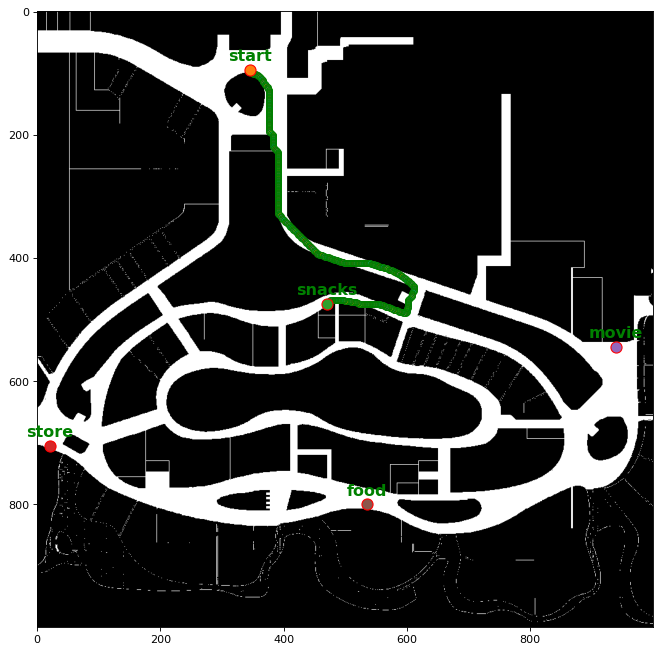

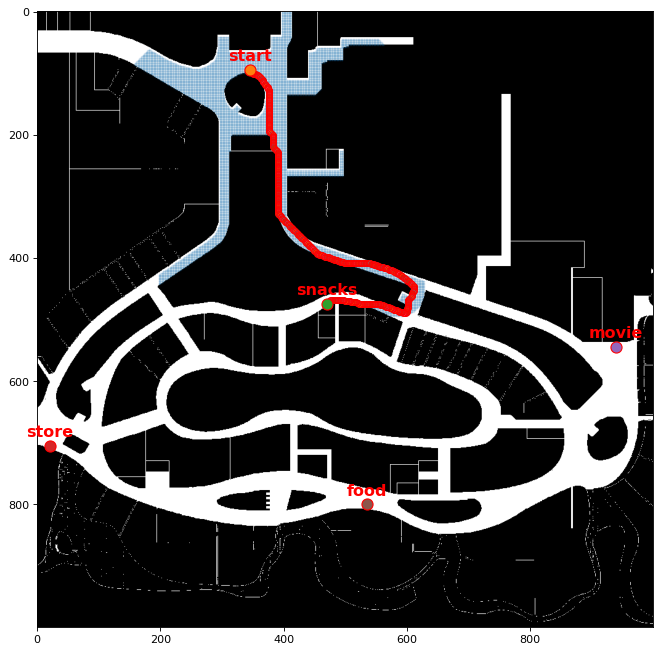

In [13]:
import dataclasses
import heapq
import math
import enum
import time
from abc import ABC, abstractmethod
import sortedcontainers

HUMAN_FOOTPRINT_RADIUS = 0.3
G_STEP_COST = 0.2
FREE = 255
OCCUPIED = 0
SEARCH_TIMEOUT_SECS = 60.0
x_bound, y_bound = grid_map.shape
TOTAL_NUM_CELLS = np.prod(grid_map.shape)
D2 = math.sqrt(2) #compute and store the sqrt 2 once to prevent expensive recomputation
D = 1.0

class Heuristic(enum.Enum):
    MANHATTAN = 0
    DIAGONAL = 1
    EUCLIDEAN = 2
    
class NeighborStrategy(enum.Enum):
    EIGHT_CONNECTED = 0
    FOUR_CONNECTED = 1
    
class FrontierType(enum.Enum):
    LAZYPQ=0
    PQ=1
    PQNOREMOVE=2
    SORTEDLIST=3
    
class SearchType(enum.Enum):
    ASTAR=0
    DJIKSTRA=1
    GREEDY=2

def get_neighbors(coord, strategy : NeighborStrategy = NeighborStrategy.EIGHT_CONNECTED) -> list:
    """
    Function that returns a list consisting of neighbors based on 8-connected neighbors
    """
    neighbors_out = []
    def append_neighbors(directions):
        for direction in directions:
            neighbors_out.append((direction[0] + coord[0], direction[1] + coord[1]))
    if strategy == NeighborStrategy.EIGHT_CONNECTED:
        diagonal_directions = ((1,1), (1,-1), (-1,1), (-1,-1))
        append_neighbors(diagonal_directions)
    directions = ((1,0), (0,1), (0,-1), (-1,0))
    append_neighbors(directions)
    return neighbors_out

def is_not_out_of_bounds(coord, x_bound, y_bound) -> bool: #return true when within the grid map
    return (0 <= coord[0] < x_bound) and (0 <= coord[1] < y_bound)

def is_collision_free(coord, grid_map) -> bool: #treturn true only when any of the grid in the inflation radius is in-bound and collided
    inflation_radius = math.ceil(HUMAN_FOOTPRINT_RADIUS / MAP_RES) - 1
    for i in range(-inflation_radius, inflation_radius+1):
        for j in range(-inflation_radius, inflation_radius+1):
            neighbor_coord = (coord[0]+i, coord[1]+j)
            if is_not_out_of_bounds(neighbor_coord, grid_map.shape[0], grid_map.shape[1]) \
                and grid_map[neighbor_coord[0], neighbor_coord[1]] == OCCUPIED:
                return False
    return True
    
def get_euclidean_distance(a, b) -> float:
    return np.linalg.norm(np.array(a)-np.array(b))
    
def get_goal_heuristic(coord, goal, heuristic_type : Heuristic = Heuristic.EUCLIDEAN) -> float:
    """
    Returns the heuristic function h(x)
    """
    if heuristic_type == Heuristic.EUCLIDEAN:
        return get_euclidean_distance(coord, goal)
    dx = abs(coord[0] - goal[0])
    dy = abs(coord[1] - goal[1])
    if heuristic_type == Heuristic.DIAGONAL:
        return D * (dx + dy) + (D2 - 2 * D) * min(dx, dy)
    elif heuristic_type == Heuristic.MANHATTAN:
        return abs(coord[0] - goal[0]) + abs(coord[1] - goal[1])

def get_rotation_heuristic(direction1, direction2):
    unit_vector_direction1 = direction1 / np.linalg.norm(direction1)
    unit_vector_direction2 = direction2 / np.linalg.norm(direction2)
    dot_product = np.dot(unit_vector_direction1, unit_vector_direction2)
    angle = np.arccos(dot_product) * 360.0 / math.pi
    return round(angle/90.0,0)

def is_goal(coord, goal, epsilon : float = 0.01) -> bool:
    return get_euclidean_distance(coord, goal) <= epsilon

def compute_path_length(path : list) -> float:
    """
    Returns path length in float scaled by the map_resolution
    e.g [(0,0), (1,1)] -> 0.2 *
    """
    if len(path) < 2:
        return 0.0
    delta = np.diff(path, axis=0)
    dist = np.apply_along_axis(lambda a : np.linalg.norm(a), 1, delta)
    return np.sum(dist) * MAP_RES

class State:
    def __init__(self, coord, gscore: float = math.inf, fscore: float = math.inf):
        self.parent = None
        self.coord = tuple(coord)
        self.g_cost = gscore
        self.f_cost = fscore
        self.visited = False
    
    def pack_as_pq_item(self) -> tuple:
        return (self.f_cost, self.coord) #(f_cost,(x,y))
    
    def __eq__(self, other):
        return self.coord == other.coord
    
    def __lt__(self, other):
        return self.f_cost < other.f_cost

def get_path_backtrack(state : State) -> list:
    path = [state.coord]
    while state.parent is not None:
        path.append(state.parent.coord)
        state = state.parent
    return path[::-1]

def get_state_from_coord(state, states_matrix) -> State:
    return states_matrix[state[0]][state[1]]

class Frontier(ABC):        
    @abstractmethod
    def push(self, item):
        ...
        
    @abstractmethod
    def pop(self):
        ...
        
    @abstractmethod
    def remove(self, item):
        ...
        
    @abstractmethod
    def not_empty(self):
        ...
    
class LazyPQ(Frontier):
    def __init__(self):
        self.q = []
        self.n = 0
        self.toremove = dict()
        
    def push(self, item):
        heapq.heappush(self.q, item)
        self.n +=1
        
    def pop(self):
        item = self.top()
        heapq.heappop(self.q)
        self.n -= 1
        return item
        
    def remove(self, item):
        self.n -= 1
        self.toremove[item] = self.toremove.get(item,0) + 1
        
    def not_empty(self):
        return self.n > 0
        
    def top(self):
        item = self.q[0]
        while self.toremove.get(item,0) > 0:
            self.toremove[item] -= 1
            heapq.heappop(self.q)
            item = self.q[0]
        return item
    
class PQ(Frontier):
    def __init__(self, do_remove : bool):
        self.q = []
        self.do_remove = do_remove
        
    def push(self, item):
        heapq.heappush(self.q, item)
        
    def pop(self):
        item = self.q[0]
        heapq.heappop(self.q)
        return item
        
    def remove(self, item):
        if not self.do_remove:
            return
        self.q.remove(item)
        heapq.heapify(self.q)
        
    def not_empty(self):
        return len(self.q) > 0

class SortedList(Frontier):
    def __init__(self) -> None:
        self.sortedlist = sortedcontainers.SortedList(key=lambda x: x[0])

    def push(self, item) -> None:
        self.sortedlist.add(item)

    def pop(self):
        item = self.sortedlist.pop(0)
        return item

    def remove(self, item) -> None:
        self.sortedlist.remove(item)

    def not_empty(self):
        return len(self.sortedlist) > 0

@dataclasses.dataclass
class AlgorithmOutput:
    total_runtime_secs : float = 0.0
    total_travelled_distance_m : float = 0.0
    visited_cells: list = dataclasses.field(default_factory=list)
    num_cells_visited : int = 0
    num_removed_from_frontiers : int = 0
    num_old_cells_detected : int = 0
    planned_path : list = dataclasses.field(default_factory=list) 
    percentage_cells_visited : float = 0
    percentage_removed_from_frontiers : float = 0
    percentage_old_cells_detected : float = 0
    
    def __str__(self):
        """Returns a string containing only the non-default field values."""
        s = ''.join(f'\n{field.name} = {getattr(self, field.name)}'
                    for field in dataclasses.fields(self) if field.name!='visited_cells')
        return f'{type(self).__name__}({s})'

def get_frontier(frontier_type : FrontierType) -> Frontier:
    if frontier_type == FrontierType.SORTEDLIST:
        return SortedList()
    elif frontier_type == FrontierType.LAZYPQ:
        return LazyPQ()
    elif frontier_type == FrontierType.PQ:
        return PQ(do_remove=True)
    elif frontier_type == FrontierType.PQNOREMOVE:
        return PQ(do_remove=False)
    
@dataclasses.dataclass
class AlgorithmSettings:
    search_type : SearchType
    frontier_type : FrontierType
    neighbor_strategy : NeighborStrategy
    heuristic_function : Heuristic
    use_rotation_heuristic : bool

def find_path(start_location : str, goal_location : str, algorithm_settings : AlgorithmSettings) -> AlgorithmOutput:
    start_coord = locations[start_location]
    goal_coord = locations[goal_location]
    
    states_matrix = [[State((i,j)) for j in range(grid_map.shape[1])] for i in range(grid_map.shape[0])]
    
    start = time.time()
    pq = get_frontier(algorithm_settings.frontier_type)
    
    cur_state = get_state_from_coord(start_coord, states_matrix)
    cur_state.f_cost = 0.0
    cur_state.g_cost = 0.0
    pq.push(cur_state.pack_as_pq_item())
    
    out = AlgorithmOutput()
    while pq.not_empty():
        if time.time() - start > SEARCH_TIMEOUT_SECS:
            print("Killing... taking too long")
            break
        (f_cost , cur_coord) = pq.pop()
        cur_state = get_state_from_coord(cur_coord, states_matrix)
        
        #SHUFFLE THE EARLY EXIT CODE
        if is_goal(cur_coord, goal_coord):
            out.planned_path = get_path_backtrack(cur_state)
            break

        if f_cost > cur_state.f_cost:
            # If an old f cost is detected, skip this
            out.num_old_cells_detected += 1
            continue
        cur_state.visited = True
        out.visited_cells.append(cur_coord)
        out.num_cells_visited += 1
        filter_neighbor_fn = lambda coord : is_not_out_of_bounds(coord, x_bound, y_bound) and is_collision_free(coord, grid_map)
        visitable_neighbors = filter(filter_neighbor_fn, get_neighbors(cur_coord, strategy=algorithm_settings.neighbor_strategy))
        for neighbor in visitable_neighbors:
            neighbor_state = get_state_from_coord(neighbor, states_matrix)
            if neighbor_state.visited:
                continue
            
            new_g = cur_state.g_cost + G_STEP_COST * get_euclidean_distance(cur_coord, neighbor) #re-look at this code
            new_h = get_goal_heuristic(neighbor, goal_coord, heuristic_type=algorithm_settings.heuristic_function) * MAP_RES #would this code still be valid, if heuristic function changes to manhattan or diagonal?
            if algorithm_settings.use_rotation_heuristic and cur_state.parent is not None:
                new_h += get_rotation_heuristic(np.array(neighbor) - np.array(cur_coord), np.array(cur_coord) - np.array(cur_state.parent.coord))
            new_f = new_g * (algorithm_settings.search_type in (SearchType.ASTAR, SearchType.DJIKSTRA)) \
                    + new_h * (algorithm_settings.search_type in (SearchType.ASTAR, SearchType.GREEDY))
    
            old_f = neighbor_state.f_cost
            old_g = neighbor_state.g_cost
            
            if new_f >= old_f: continue
            
            if not math.isinf(old_f):
                out.num_removed_from_frontiers += 1 
                # Means it is currently in open list
                pq.remove(neighbor_state.pack_as_pq_item())
                
            neighbor_state.parent = cur_state
            neighbor_state.g_cost = new_g
            neighbor_state.f_cost = new_f
            pq.push(neighbor_state.pack_as_pq_item())
            
    out.total_runtime_secs = time.time() - start
    out.total_travelled_distance_m = compute_path_length(out.planned_path)
    out.percentage_cells_visited = out.num_cells_visited / TOTAL_NUM_CELLS
    out.percentage_removed_from_frontiers = out.num_removed_from_frontiers / TOTAL_NUM_CELLS
    out.percentage_old_cells_detected = out.num_old_cells_detected / TOTAL_NUM_CELLS
    return out

start_goal_pairs = [(start, goal) for start in locations.keys() for goal in locations.keys() if start != goal]
num_locations = len(locations.keys())
distance_table = np.zeros((num_locations, num_locations))
straight_line_distance_table = np.zeros((num_locations, num_locations))
locations_to_idx = {"start" : 0, "snacks" : 1, "store" : 2, "movie" : 3, "food" : 4}
idx_to_locations = {val : key for key,val in locations_to_idx.items()}

# A helper function to plot path on the map
def plot_path(path : list, color: 'str'='black'):
    for points in path:
        plt.plot(points[0], points[1], marker="o", markersize=5, markeredgecolor=color)
    for key, _ in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')   
    return

def plot_visited(visited: list):
    x_pt = [0]*len(visited)
    y_pt = x_pt.copy()
    for i in range(len(visited)):
        x_pt[i], y_pt[i] = visited[i][0], visited[i][1]
    plt.scatter(x_pt,y_pt,marker='.',s=0.01)

def plot_distance_table(distance_table):
    column_width = 10
    header = f'From/' + (' ' * (column_width - len('From/')))
    for location in locations.keys():
        header += f'{location}' + (' ' * (column_width-len(location)))
    header += '\nto'
    print(header)
    
    for row_id in range(len(distance_table)):
        row_location = idx_to_locations[row_id]
        row = row_location + (' ' * (column_width - len(row_location)))
        for dist in distance_table[row_id]:
            number = format(dist,'.4f')
            row += number + (' ' * (column_width - len(number)))
        print(row)
    
out_dict = dict()
for start_goal_pair in start_goal_pairs:
    start, goal = start_goal_pair
    print('-' * 100)
    print("Planning path for ", start_goal_pair)
    algorithm_settings = AlgorithmSettings(
        search_type = SearchType.ASTAR,
        frontier_type=FrontierType.PQNOREMOVE, 
        neighbor_strategy=NeighborStrategy.EIGHT_CONNECTED, 
        heuristic_function=Heuristic.DIAGONAL,
        use_rotation_heuristic=False)
    out = find_path(start, goal, algorithm_settings)
    out_dict[(start,goal)] = out
    print(out)
    distance_table[locations_to_idx[goal], locations_to_idx[start]] = out.total_travelled_distance_m
    straight_line_distance_table[locations_to_idx[goal], locations_to_idx[start]] = get_euclidean_distance(locations[start], locations[goal]) * MAP_RES
    
    # drawing path
    fig = plt.figure(figsize=(20, 10), dpi=80)
    plt.imshow(grid_map_img, cmap='gray')
    plot_path(out.planned_path, color='green')
    plot_visited(out.visited_cells)
    
    print()
    # drawing distance table
    print("Planned path distance table")    
    plot_distance_table(distance_table)
    
    print()
    print("Straight line distance table")    
    # drawing straight line distance table
    plot_distance_table(straight_line_distance_table)

## Task 2

Travelling salesman problem using distance table below!
From/     start     snacks    store     movie     food      
to
start     0.0000    142.4857  155.1332  178.8906  223.3239  
snacks    142.4857  0.0000    114.7945  107.5092  133.4288  
store     155.1332  114.7945  0.0000    209.4171  110.8701  
movie     178.8906  107.5092  209.4171  0.0000    113.7235  
food      223.3239  133.4288  110.8701  113.7235  0.0000    
Strategy  TSPStrategy.BRUTE_FORCE
TSPOutput(path=[0, 2, 4, 3, 1, 0], total_distance=629.7216879903424, runtime_ns=197500)
Strategy  TSPStrategy.DP
TSPOutput(path=[0, 2, 4, 3, 1, 0], total_distance=629.7216879903424, runtime_ns=81100)
Strategy  TSPStrategy.GREEDY
TSPOutput(path=[0, 1, 3, 4, 2, 0], total_distance=629.7216879903425, runtime_ns=13300)


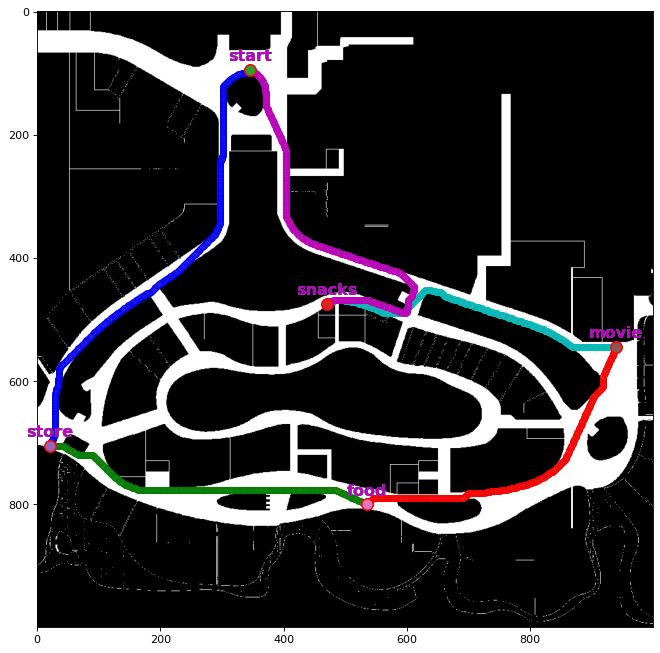

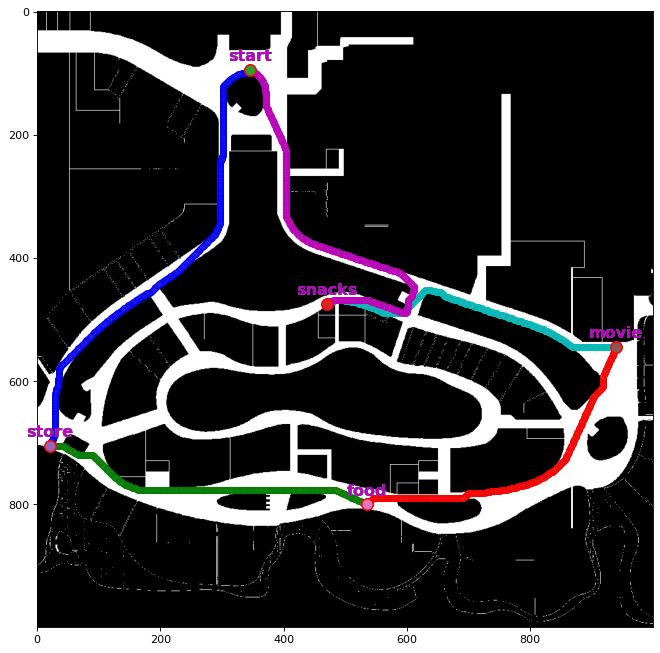

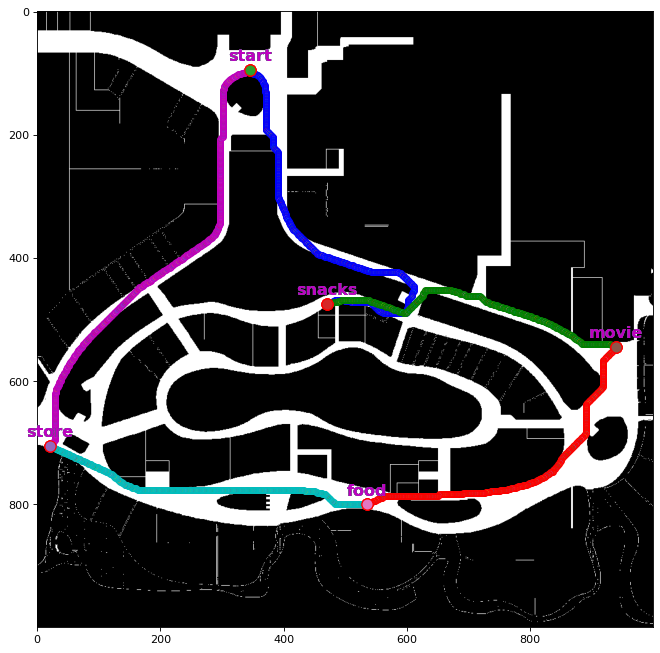

In [ ]:
@dataclasses.dataclass
class TSPOutput:
    path : list
    total_distance : float
    runtime_ns : float
    
def get_all_possible_paths(nodes) -> list:
    if not nodes:
        return []
    if len(nodes) == 1:
        return [nodes]
    out_paths = []
    for node in nodes:
        subproblem = get_all_possible_paths([n for n in nodes if n != node])
        for subpath in subproblem:
            tmp_path = [node]
            tmp_path.extend(subpath)
            out_paths.append(tmp_path)
    return out_paths
    
def brute_force_tsp(graph, start) -> TSPOutput:
    out_path, path_cost, start_time = [start], 0.0, time.perf_counter_ns()
    nodes = [n for n in range(len(graph)) if n != start]
    all_possible_paths = get_all_possible_paths(nodes)
    
    path_cost = math.inf
    for path in all_possible_paths:
        cur_path_cost = 0
        cur_node = start
        for dest_node in path:
            cur_path_cost += graph[cur_node][dest_node]
            cur_node = dest_node
        # cost from last node back to start node
        cur_path_cost += graph[cur_node][start]
        
        if cur_path_cost < path_cost:
            path_cost = cur_path_cost
            out_path = [start] + path[:]
            out_path.append(start)
    return TSPOutput(out_path, path_cost, time.perf_counter_ns() - start_time)

def greedy_tsp(graph, start) -> TSPOutput:
    out_path, path_cost, start_time = [start], 0.0, time.perf_counter_ns()
    num_nodes = len(graph)
    visited = [False] * num_nodes
    visited[start] = True
    
    cur_node = start
    while len(out_path) < num_nodes:
        lowest_cost_node = None
        lowest_cost = math.inf
        
        for node in range(num_nodes):
            if not visited[node]:
                cost = graph[cur_node][node]
                if cost < lowest_cost:
                    lowest_cost = cost
                    lowest_cost_node = node
        
        cur_node = lowest_cost_node
        out_path.append(cur_node)
        visited[cur_node] = True
        path_cost += lowest_cost
        
    out_path.append(start)
    path_cost += graph[cur_node][start]
    return TSPOutput(out_path, path_cost, time.perf_counter_ns() - start_time)

def dp_tsp(graph, start) -> TSPOutput:
    """
    Adopted from https://towardsdev.com/traveling-salesman-problem-dynamic-programming-solution-1d161c34bb1a
    """
    out_path, path_cost, start_time = [start], 0.0, time.perf_counter_ns()

    def memo_dp(current_node, rest_nodes, memo={}, path=[]):
        rest_nodes = tuple(rest_nodes)
        
        if (current_node, rest_nodes) in memo:
            return memo[(current_node, rest_nodes)], path
        
        if not rest_nodes:
            return graph[current_node,start], path + [start]
        
        min_distance = float('inf')
        for i in range(len(rest_nodes)):
            next_node = rest_nodes[i]
            new_remaining_nodes = rest_nodes[:i] + rest_nodes[i+1:]
            d, p = memo_dp(next_node, new_remaining_nodes, memo, path + [next_node])
            d += graph[current_node,next_node]
            if d < min_distance:
                min_distance = d
                out_path = p
        memo[(current_node, rest_nodes)] = min_distance
        return min_distance, out_path
    rest_nodes = [n for n in range(len(graph)) if n != start]
    path_cost, out_path = memo_dp(start, rest_nodes)
    return TSPOutput([start] + out_path, path_cost, time.perf_counter_ns() - start_time)

class TSPStrategy(enum.Enum):
    BRUTE_FORCE=0
    DP=1
    GREEDY=2

def tsp(graph, start, strategy : TSPStrategy = TSPStrategy.BRUTE_FORCE):
    if strategy == TSPStrategy.BRUTE_FORCE:
        return brute_force_tsp(graph, start)
    elif strategy == TSPStrategy.DP:
        return dp_tsp(graph, start)
    elif strategy == TSPStrategy.GREEDY:
        return greedy_tsp(graph, start)
    
def plot_tsp_path(tsp_path):
    fig = plt.figure(figsize=(20, 10), dpi=80)
    plt.imshow(grid_map_img, cmap='gray')
    colors = 'bgrcm'
    for i in range(len(tsp_out.path)-1):
        src = tsp_out.path[i]
        dest = tsp_out.path[i+1]
        out = out_dict[(idx_to_locations[src], idx_to_locations[dest])]
        plot_path(out.planned_path, color=colors[i])
      
strategies = [TSPStrategy(e.value) for e in TSPStrategy]
print("Travelling salesman problem using distance table below!")
plot_distance_table(distance_table)
for strategy in strategies:
    print("Strategy ", strategy)
    tsp_out = tsp(distance_table, 0, strategy=strategy)      
    print(tsp_out)
    plot_tsp_path(tsp_out) 
